# Define segment and predict sales associated

## Importations of packages 

In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import os
import s3fs
import re
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score
from sklearn.utils import class_weight
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler
from sklearn.metrics import make_scorer, f1_score, balanced_accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.exceptions import ConvergenceWarning, DataConversionWarning
from sklearn.naive_bayes import GaussianNB
from scipy.optimize import fsolve
import io

import pickle
import warnings

## load databases

In [2]:
# Create filesystem object
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})

In [75]:
type_of_activity = "musique"

In [4]:
def load_train_test(type_of_activity):
    # BUCKET = f"projet-bdc2324-team1/Generalization/{type_of_activity}"
    BUCKET = f"projet-bdc2324-team1/Generalization_v2/{type_of_activity}"
    File_path_train = BUCKET + "/Train_set.csv"
    File_path_test = BUCKET + "/Test_set.csv"
    
    with fs.open( File_path_train, mode="rb") as file_in:
        dataset_train = pd.read_csv(file_in, sep=",")
        # dataset_train['y_has_purchased'] = dataset_train['y_has_purchased'].fillna(0)

    with fs.open(File_path_test, mode="rb") as file_in:
        dataset_test = pd.read_csv(file_in, sep=",")
        # dataset_test['y_has_purchased'] = dataset_test['y_has_purchased'].fillna(0)
    
    return dataset_train, dataset_test

In [76]:
dataset_train, dataset_test = load_train_test(type_of_activity)
dataset_train.isna().sum()

/tmp/ipykernel_552/3983721681.py:8: DtypeWarning: Columns (10,19,20,21,24) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset_train = pd.read_csv(file_in, sep=",")
/tmp/ipykernel_552/3983721681.py:12: DtypeWarning: Columns (19,20,21,24) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset_test = pd.read_csv(file_in, sep=",")


customer_id              0
street_id                0
structure_id        327020
mcp_contact_id      135470
fidelity                 0
                     ...  
purchases_8_2021    113963
purchases_8_2022         0
purchases_9_2021    113963
purchases_9_2022         0
y_has_purchased          0
Length: 87, dtype: int64

In [17]:
def features_target_split(dataset_train, dataset_test):
    
    features_l = ['nb_tickets', 'nb_purchases', 'total_amount', 'nb_suppliers', 'purchase_date_min', 'purchase_date_max', 
            'time_between_purchase', 'fidelity',  'is_email_true', 'opt_in', #'is_partner', 'nb_tickets_internet',, 'vente_internet_max'
            'gender_female', 'gender_male', 'gender_other', 'nb_campaigns', 'nb_campaigns_opened']

    # we suppress fidelity, time between purchase, and gender other (colinearity issue)
    """
    features_l = ['nb_tickets', 'nb_purchases', 'total_amount', 'nb_suppliers', 'vente_internet_max', 
                  'purchase_date_min', 'purchase_date_max', 'nb_tickets_internet',  'is_email_true', 
                  'opt_in', 'gender_female', 'gender_male', 'nb_campaigns', 'nb_campaigns_opened']
    """
    
    X_train = dataset_train # [features_l]
    y_train = dataset_train[['y_has_purchased']]

    X_test = dataset_test # [features_l]
    y_test = dataset_test[['y_has_purchased']]
    return X_train, X_test, y_train, y_test

In [77]:
X_train, X_test, y_train, y_test = features_target_split(dataset_train, dataset_test)
print("Shape train : ", X_train.shape)
print("Shape test : ", X_test.shape)

Shape train :  (354365, 87)
Shape test :  (151874, 87)


## get results from the logit cross validated model

In [78]:
X_test

customer_id  street_id  structure_id  mcp_contact_id  fidelity  \
0        10_699783        139           NaN        186852.0         0   
1         10_38307        862           NaN         17621.0         7   
2        10_556101       1063           NaN        136909.0         0   
3        10_686663     443226           NaN        186611.0         1   
4         10_91656     316684           NaN         21559.0         2   
...            ...        ...           ...             ...       ...   
151869  14_1843791     718883         224.0        394849.0         1   
151870  14_4630858     741826           NaN       1555631.0         0   
151871  14_4659926     871477           NaN       1542180.0         0   
151872  14_4881492     917272           NaN             NaN         1   
151873     14_8124       2762           NaN         10077.0         2   

        tenant_id  is_partner  deleted_at  is_email_true  opt_in  ...  \
0             875       False         NaN           True       0  ...   
1             875       False         NaN           True       0  ...   
2             875       False         NaN           True       1  ...   
3             875       False         NaN           True       1  ...   
4             875       False         NaN           True       0  ...   
...           ...         ...         ...            ...     ...  ...   
151869        862       False         NaN           True       1  ...   
151870        862       False         NaN           True       1  ...   
151871        862       False         NaN           True       1  ...   
151872        862       False         NaN           True       1  ...   
151873        862       False         NaN           True       0  ...   

       purchases_5_2022 purchases_6_2021  purchases_6_2022  purchases_7_2021  \
0                   0.0              0.0               0.0               0.0   
1                   0.0              0.0               0.0               0.0   
2                   0.0              0.0               0.0               0.0   
3                   0.0              0.0               0.0               0.0   
4                   0.0              0.0               0.0               0.0   
...                 ...              ...               ...               ...   
151869              0.0              NaN               0.0               NaN   
151870              0.0              NaN               0.0               NaN   
151871              0.0              NaN               0.0               NaN   
151872              0.0              NaN               0.0               NaN   
151873              0.0              NaN               0.0               NaN   

        purchases_7_2022  purchases_8_2021  purchases_8_2022  \
0                    0.0               0.0               0.0   
1                    0.0               0.0               0.0   
2                    0.0               0.0               0.0   
3                    0.0               0.0               1.0   
4                    0.0               0.0               0.0   
...                  ...               ...               ...   
151869               0.0               NaN               0.0   
151870               0.0               NaN               0.0   
151871               0.0               NaN               0.0   
151872               0.0               NaN               0.0   
151873               0.0               NaN               0.0   

        purchases_9_2021  purchases_9_2022 y_has_purchased  
0                    0.0               0.0             0.0  
1                    0.0               0.0             0.0  
2                    0.0               0.0             0.0  
3                    0.0               0.0             0.0  
4                    0.0               0.0             0.0  
...                  ...               ...             ...  
151869               NaN               0.0             0.0  
151870               NaN           

In [20]:
def load_model(type_of_activity, model):
    # BUCKET = f"projet-bdc2324-team1/Output_model/{type_of_activity}/{model}/"
    BUCKET = f"projet-bdc2324-team1/basique/{type_of_activity}/{model}/"
    filename = model + '.pkl'
    file_path = BUCKET + filename
    with fs.open(file_path, mode="rb") as f:
        model_bytes = f.read()

    model = pickle.loads(model_bytes)
    return model

In [92]:
model = load_model(type_of_activity, "LogisticRegression_Benchmark")
# model = load_model(type_of_activity, "randomF_cv")
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['nb_campaigns',
                                                   'taux_ouverture_mail',
                                                   'prop_purchases_internet',
                                                   'nb_tickets', 'nb_purchases',
                                                   'total_amount',
                                                   'nb_suppliers',
                                                   'purchases_10_2021',
                                                   'purchases_10_2022',
                                                   'purchases_...
                                                   'categorie_age_40_50',
                                                   'categorie_age_50_60',
                                                   'categorie_age_60_70',
                                                   'categorie_age_70_80',
                                                   'categorie_age_plus_80',
                                                   'categorie_age_inconnue',
                                                   'country_fr',
                                                   'is_profession_known',
                                                   'is_zipcode_known',
                                                   'opt_in'])])),
                ('LogisticRegression_Benchmark',
                 LogisticRegression(class_weight={0.0: 0.5480249666729557,
                                                  1.0: 5.705625684291879},
                                    max_iter=5000, n_jobs=-1, solver='saga'))])

## Quartile clustering

In [93]:
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

In [94]:
X_test_segment = X_test

X_test_segment["has_purchased"] = y_test
X_test_segment["has_purchased_estim"] = y_pred
X_test_segment["score"] = y_pred_prob
X_test_segment["quartile"] = np.where(X_test['score']<0.25, '1',
                   np.where(X_test['score']<0.5, '2',
                   np.where(X_test['score']<0.75, '3', '4')))
X_test_segment.head(10)

customer_id  street_id  structure_id  mcp_contact_id  fidelity  tenant_id  \
0   10_699783        139           NaN        186852.0         0        875   
1    10_38307        862           NaN         17621.0         7        875   
2   10_556101       1063           NaN        136909.0         0        875   
3   10_686663     443226           NaN        186611.0         1        875   
4    10_91656     316684           NaN         21559.0         2        875   
5    10_35956     106204           NaN             NaN         1        875   
6   10_560058       1063           NaN        161812.0         0        875   
7    10_38603     513642        1865.0          7660.0         4        875   
8   10_563294       1063           NaN        167549.0         0        875   
9   10_548983     268636           NaN        173318.0         1        875   

   is_partner  deleted_at  is_email_true  opt_in  ... purchases_8_2021  \
0       False         NaN           True       0  ...              0.0   
1       False         NaN           True       0  ...              0.0   
2       False         NaN           True       1  ...              0.0   
3       False         NaN           True       1  ...              0.0   
4       False         NaN           True       0  ...              0.0   
5       False         NaN           True       0  ...              0.0   
6       False         NaN           True       1  ...              0.0   
7       False         NaN           True       1  ...              0.0   
8       False         NaN           True       1  ...              0.0   
9       False         NaN           True       0  ...              0.0   

  purchases_8_2022  purchases_9_2021  purchases_9_2022  y_has_purchased  \
0              0.0               0.0               0.0              0.0   
1              0.0               0.0               0.0              0.0   
2              0.0               0.0               0.0              0.0   
3              1.0               0.0               0.0              0.0   
4              0.0               0.0               0.0              0.0   
5              0.0               0.0               0.0              0.0   
6              0.0               0.0               0.0              0.0   
7              0.0               0.0               0.0              1.0   
8              0.0               0.0               0.0              0.0   
9              0.0               0.0               0.0              0.0   

   has_purchased  has_purchased_estim     score  quartile score_adjusted  
0            0.0                  0.0  0.131180         1       0.017574  
1            0.0                  0.0  0.321635         2       0.042466  
2            0.0                  0.0  0.005068         1       0.000676  
3            0.0                  0.0  0.166979         1       0.018397  
4            0.0                  0.0  0.161523         1       0.018632  
5            0.0                  0.0  0.098139         1       0.010129  
6            0.0                  0.0  0.005377         1       0.000715  
7            1.0                  1.0  0.906698         4       0.461388  
8            0.0                  0.0  0.007399         1       0.000974  
9            0.0                  0.0  0.163529         1       0.022102  

[10 rows x 92 columns]

In [24]:
def df_segment(df, y, model) :

    y_pred = model.predict(df)
    y_pred_prob = model.predict_proba(df)[:, 1]

    df_segment = df

    df_segment["has_purchased"] = y
    df_segment["has_purchased_estim"] = y_pred
    df_segment["score"] = y_pred_prob
    df_segment["quartile"] = np.where(df_segment['score']<0.25, '1',
                       np.where(df_segment['score']<0.5, '2',
                       np.where(df_segment['score']<0.75, '3', '4')))

    return df_segment

In [88]:
df_segment(X_test, y_test, model)

/tmp/ipykernel_1080/2624515794.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_segment["has_purchased"] = y
/tmp/ipykernel_1080/2624515794.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_segment["has_purchased_estim"] = y_pred
/tmp/ipykernel_1080/2624515794.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

nb_tickets  nb_purchases  total_amount  nb_suppliers  \
0             4.0           1.0        100.00           1.0   
1             1.0           1.0         55.00           1.0   
2            17.0           1.0         80.00           1.0   
3             4.0           1.0        120.00           1.0   
4            34.0           2.0        416.00           1.0   
...           ...           ...           ...           ...   
96091         1.0           1.0         67.31           1.0   
96092         1.0           1.0         61.41           1.0   
96093         0.0           0.0          0.00           0.0   
96094         1.0           1.0         79.43           1.0   
96095         0.0           0.0          0.00           0.0   

       vente_internet_max  purchase_date_min  purchase_date_max  \
0                     0.0           5.177187           5.177187   
1                     0.0         426.265613         426.265613   
2                     0.0         436.033437         436.033437   
3                     0.0           5.196412           5.196412   
4                     0.0         478.693148         115.631470   
...                   ...                ...                ...   
96091                 1.0         278.442257         278.442257   
96092                 1.0         189.207373         189.207373   
96093                 0.0         550.000000         550.000000   
96094                 1.0         279.312905         279.312905   
96095                 0.0         550.000000         550.000000   

       time_between_purchase  nb_tickets_internet  fidelity  ...  opt_in  \
0                   0.000000                  0.0         1  ...   False   
1                   0.000000                  0.0         2  ...    True   
2                   0.000000                  0.0         2  ...    True   
3                   0.000000                  0.0         1  ...   False   
4                 363.061678                  0.0         4  ...   False   
...                      ...                  ...       ...  ...     ...   
96091               0.000000                  1.0         2  ...   False   
96092               0.000000                  1.0         1  ...   False   
96093              -1.000000                  0.0         1  ...    True   
96094               0.000000                  1.0         1  ...   False   
96095              -1.000000                  0.0         2  ...   False   

       gender_female  gender_male  gender_other  nb_campaigns  \
0                  1            0             0           0.0   
1                  0            1             0           0.0   
2                  1            0             0           0.0   
3                  1            0             0           0.0   
4                  1            0             0           0.0   
...              ...          ...           ...           ...   
96091              0            1             0          15.0   
96092              0            1             0          12.0   
96093              1            0             0          29.0   
96094              0            1             0          20.0   
96095              0            1             0          31.0   

       nb_campaigns_opened  has_purchased  has_purchased_estim     score  \
0                      0.0            0.0                  0.0  0.006066   
1                      0.0            1.0                  0.0  0.288847   
2                      0.0            0.0                  0.0  0.103264   
3                      0.0            0.0                  0.0  0.008928   
4                      0.0            1.0                  1.0  0.992809   
...                    ...            ...                  ...       ...   
96091                  5.0            1.0                  0.0  0.351762   
96092                  9.0            0.0                  1.0  0.567814   
96093                  3.0            0.0                  0.0  0.0

## definition of functions to compute the bias of scores and adjust it 

Le biais est calculé de la façon suivante. 
En notant $\hat{p(x_i)}$ le score calculé (estimé par la modélisation) et $p(x_i)$ le vrai score (sans biais), et $\beta$ le logarithme du biais, on a : \
$\ln{\frac{\hat{p(x_i)}}{1-\hat{p(x_i)}}} = \beta + \ln{\frac{p(x_i)}{1-p(x_i)}}$ \
$ \frac{\hat{p(x_i)}}{1-\hat{p(x_i)}} = \exp(\beta) . \frac{p(x_i)}{1-p(x_i)} $ , soit : \
$p(x_i) = {\frac{\frac{\hat{p(x_i)}}{1-\hat{p(x_i)}}}{B+\frac{\hat{p(x_i)}}{1-\hat{p(x_i)}}}}$ \
Ce qu'on appelle biais et qu'on estime dans le code par la suite est : $B=\exp(\beta) $. Les probabilités ne sont donc pas biaisées si $B=1$. Il y a surestimation si $B>1$. 

On cherche le B qui permette d'ajuster les probabilités de telle sorte que la somme des scores soit égale à la somme des y_has_purchased. Cela revient à résoudre : 

\begin{equation}
\sum_{i}{\frac{\frac{\hat{p(x_i)}}{1-\hat{p(x_i)}}}{B+\frac{\hat{p(x_i)}}{1-\hat{p(x_i)}}}} = \sum_{i}{Y_i}
\end{equation}

C'est ce que fait la fonction find_bias. 

Note sur les notations : \
$\hat{p(x_i)}$ correspond à ce qu'on appelle le score et $p(x_i)$ à ce qu'on appellera le score adjusted

In [25]:
# compute adjusted score from odd ratios (cf formula above)
def adjusted_score(odd_ratio, bias) :
    adjusted_score = odd_ratio/(bias+odd_ratio)
    return adjusted_score

In [26]:
# when the score is 1 we cannot compute the odd ratio, so we adjust scores equal to 1
# we set the second best score instead

def adjust_score_1(score) :
    second_best_score = np.array([element for element in score if element !=1]).max()
    new_score = np.array([element if element!=1 else second_best_score for element in score])    
    return new_score

In [27]:
def odd_ratio(score) :
    return score / (1 - score)

In [28]:
# definition of a function that automatically detects the bias

def find_bias(odd_ratios, y_objective, initial_guess=6) :
    """
    results = minimize(lambda bias : (sum([adjusted_score(element, bias) for element in list(odd_ratios)]) - y_objective)**2 ,
    initial_guess , method = "BFGS")

    estimated_bias = results.x[0]
    """

    # faster method
    bias_estimated = fsolve(lambda bias : sum([adjusted_score(element, bias) for element in list(odd_ratios)]) - y_objective, x0=6)
 
    return bias_estimated[0]

In [95]:
print(X_test_segment["score"].mean(), y_test["y_has_purchased"].mean())
y_train["y_has_purchased"].mean()

0.3000275047453295 0.08797424180570736


0.08763280798047211

In [96]:
# computation with the function defined

bias_test_set = find_bias(odd_ratios = odd_ratio(adjust_score_1(X_test_segment["score"])), 
                           y_objective = y_test["y_has_purchased"].sum(),
                           initial_guess=6)
bias_test_set

10.698758485840244

In [97]:
# comparison with bias of the train set
X_train_score = model.predict_proba(X_train)[:, 1]

bias_train_set = find_bias(odd_ratios = odd_ratio(adjust_score_1(X_train_score)), 
                           y_objective = y_train["y_has_purchased"].sum(),
                           initial_guess=10)
bias_train_set

10.688693734338177

In [98]:
print("betâ test - betâ train = ",np.log(bias_test_set/bias_train_set))

betâ test - betâ train =  0.00094118290869078


In [99]:
# impact of considering a bias computed on train set instead of test set - totally neglectable

score_adjusted_test = adjusted_score(odd_ratio(adjust_score_1(X_test_segment["score"])), bias = bias_test_set)
score_adjusted_train = adjusted_score(odd_ratio(adjust_score_1(X_test_segment["score"])), bias = bias_train_set)

print("mean absolute erreur",abs(score_adjusted_test-score_adjusted_train).mean())

mean absolute erreur 4.674943825828751e-05


In [100]:
# adjust scores accordingly 

# X_test_segment["score_adjusted"] = adjusted_score(odd_ratio(adjust_score_1(X_test_segment["score"])), bias = bias_test_set)

# actually, we are not supposed to have X_test, so the biais is estimated on X_train
# X_test_segment["score_adjusted"] = adjusted_score(odd_ratio(adjust_score_1(X_test_segment["score"])), bias = bias_train_set)
X_test_segment["score_adjusted"] = score_adjusted_train

In [101]:
# check 

MSE_score = ((X_test_segment["score"]-X_test_segment["has_purchased"])**2).mean()
MSE_ajusted_score = ((X_test_segment["score_adjusted"]-X_test_segment["has_purchased"])**2).mean()
print(f"MSE for score : {MSE_score}")
print(f"MSE for ajusted score : {MSE_ajusted_score}")

print("sum of y_has_purchased :",y_test["y_has_purchased"].sum())
print("sum of adjusted scores :", X_test_segment["score_adjusted"].sum())

MSE for score : 0.12309116071575532
MSE for ajusted score : 0.05482346713233594
sum of y_has_purchased : 13361.0
sum of adjusted scores : 13368.100024185826


In [102]:
# mean absolute error - divided by 2 with out method

MAE_score = abs(X_test_segment["score"]-X_test_segment["has_purchased"]).mean()
MAE_ajusted_score = abs(X_test_segment["score_adjusted"]-X_test_segment["has_purchased"]).mean()
print(f"MAE for score : {MAE_score}")
print(f"MAE for adjusted score : {MAE_ajusted_score}")

MAE for score : 0.25695361997840177
MAE for adjusted score : 0.10450649550597542


In [37]:
# visualization

# histogramme des probas et des probas ajustées

def plot_hist_scores(df, score, score_adjusted, type_of_activity) :

    plt.figure()
    plt.hist(df[score], label = "score", alpha=0.6)
    plt.hist(df[score_adjusted], label="adjusted score", alpha=0.6)
    plt.legend()
    plt.xlabel("probability of a future purchase")
    plt.ylabel("count")
    plt.title(f"Comparison between score and adjusted score for {type_of_activity} companies")
    # plt.show()

In [64]:
PATH + file_name + type_of_activity + ".png"

'projet-bdc2324-team1/Output_expected_CA/sport/hist_score_adjustedsport.png'

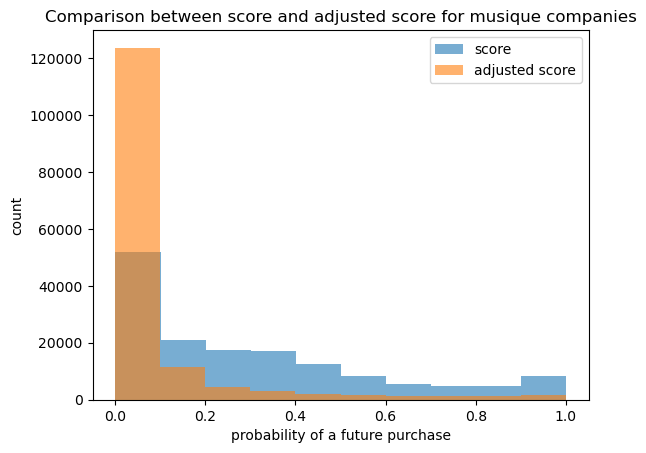

In [103]:
plot_hist_scores(X_test_segment, score = "score", score_adjusted = "score_adjusted", type_of_activity = type_of_activity)

In [40]:
# define path so save graphics

# define type of activity 
type_of_activity = "sport"
PATH = f"projet-bdc2324-team1/Output_expected_CA/{type_of_activity}/"
print(PATH)

projet-bdc2324-team1/Output_expected_CA/sport/


In [68]:
# export png 

# plot adjusted scores and save (to be tested)
plot_hist_scores(X_test_segment, score = "score", score_adjusted = "score_adjusted", type_of_activity = type_of_activity)

image_buffer = io.BytesIO()
plt.savefig(image_buffer, format='png')
image_buffer.seek(0)
file_name = "hist_score_adjusted_"
FILE_PATH_OUT_S3 = PATH + file_name + type_of_activity + ".png"
with fs.open(FILE_PATH_OUT_S3, 'wb') as s3_file:
    s3_file.write(image_buffer.read())
plt.close()

## Compute number of tickets and CA by segment with the recalibrated score

In [104]:
X_test_table_adjusted_scores = (100 * X_test_segment.groupby("quartile")[["score","score_adjusted", "has_purchased"]].mean()).round(2).reset_index()
X_test_table_adjusted_scores = X_test_table_adjusted_scores.rename(columns = {col : f"{col.replace('_', ' ')} (%)" for col in X_test_table_adjusted_scores.columns if col in ["score","score_adjusted", "has_purchased"]})
X_test_table_adjusted_scores

quartile  score (%)  score adjusted (%)  has purchased (%)
0        1       8.80                0.94               1.02
1        2      36.16                5.17               4.70
2        3      61.06               13.33              14.62
3        4      89.86               53.74              53.19

In [162]:
X_test_table_adjusted_scores.to_latex(index=False)

'\\begin{tabular}{lrrr}\n\\toprule\nquartile & score (%) & score adjusted (%) & has purchased (%) \\\\\n\\midrule\n1 & 13.250000 & 2.510000 & 1.570000 \\\\\n2 & 33.890000 & 8.000000 & 9.850000 \\\\\n3 & 63.060000 & 22.580000 & 21.470000 \\\\\n4 & 90.520000 & 66.200000 & 65.010000 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [43]:
# comparison between score and adjusted score - export csv associated

file_name = "table_adjusted_score_"
FILE_PATH_OUT_S3 = PATH + file_name +  type_of_activity + ".csv"
with fs.open(FILE_PATH_OUT_S3, 'w') as file_out:
    X_test_table_adjusted_scores.to_csv(file_out, index = False)

In [40]:
def project_tickets_CA (df, nb_purchases, nb_tickets, total_amount, score_adjusted, duration_ref, duration_projection) :
    
    duration_ratio = duration_ref/duration_projection

    df_output = df

    df_output.loc[:,"nb_tickets_projected"] = df_output.loc[:,nb_tickets] / duration_ratio
    df_output.loc[:,"total_amount_projected"] = df_output.loc[:,total_amount] / duration_ratio
    
    df_output.loc[:,"nb_tickets_expected"] = df_output.loc[:,score_adjusted] * df_output.loc[:,"nb_tickets_projected"]
    df_output.loc[:,"total_amount_expected"] = df_output.loc[:,score_adjusted] * df_output.loc[:,"total_amount_projected"]

    df_output.loc[:,"pace_purchase"] = (duration_ref/df_output.loc[:,nb_purchases]).apply(lambda x : np.nan if x==np.inf else x)
    
    return df_output


In [41]:
X_test_segment = project_tickets_CA (X_test_segment, "nb_purchases", "nb_tickets", "total_amount", "score_adjusted", 
                                     duration_ref=17, duration_projection=12)
X_test_segment

customer_id  street_id  structure_id  mcp_contact_id  fidelity  \
0           1_8191       8114           NaN           834.0         0   
1          1_14792          2           NaN        251178.0         0   
2          1_30466          2           NaN          2355.0         0   
3          1_41898      20244      203714.0         97973.0         0   
4          1_58746          2           NaN         82026.0         1   
...            ...        ...           ...             ...       ...   
186115     4_24295     103884           NaN         96913.0         0   
186116     4_44443      43315           NaN        234734.0         0   
186117   4_3343947          2           NaN             NaN         1   
186118     4_47752      46460           NaN         89791.0         0   
186119     4_35449      34592           NaN        119197.0         0   

        tenant_id  is_partner  deleted_at  is_email_true  opt_in  ...  \
0            1311       False         NaN           True       1  ...   
1            1311       False         NaN           True       1  ...   
2            1311       False         NaN           True       1  ...   
3            1311       False         NaN           True       1  ...   
4            1311       False         NaN           True       1  ...   
...           ...         ...         ...            ...     ...  ...   
186115       1342       False         NaN           True       1  ...   
186116       1342       False         NaN           True       0  ...   
186117       1342       False         NaN           True       0  ...   
186118       1342       False         NaN           True       1  ...   
186119       1342       False         NaN           True       1  ...   

       has_purchased has_purchased_estim     score  quartile  score_adjusted  \
0                0.0                 0.0  0.408546         2        0.027066   
1                0.0                 0.0  0.027046         1        0.001118   
2                0.0                 0.0  0.180851         1        0.008813   
3                0.0                 0.0  0.220872         1        0.011288   
4                0.0                 0.0  0.100951         1        0.004502   
...              ...                 ...       ...       ...             ...   
186115           0.0                 0.0  0.466644         2        0.034037   
186116           0.0                 0.0  0.427641         2        0.029211   
186117           0.0                 0.0  0.468464         2        0.034278   
186118           0.0                 0.0  0.360100         2        0.022161   
186119           0.0                 1.0  0.728907         3        0.097705   

        nb_tickets_projected  total_amount_projected  nb_tickets_expected  \
0                   0.000000                0.000000             0.000000   
1                   0.000000                0.000000             0.000000   
2                   0.000000                0.000000             0.000000   
3                   0.000000                0.000000             0.000000   
4                   0.000000                0.000000             0.000000   
...                      ...                     ...                  ...   
186115              0.000000                0.000000             0.000000   
186116              0.000000                0.000000             0.000000   
186117              0.705882               20.470588             0.024196   
186118              0.000000                0.000000             0.000000   
186119              0.000000                0.000000             0.000000   

        total_amount_expected  pace_purchase  
0                    0.000000            NaN  
1                    0.000000            NaN  
2                    0.000000            NaN  
3                    0.000000            NaN  
4                    0.000000            NaN  
...                       ...            ...  
186115               0.000000         

In [42]:
X_test_segment.groupby("quartile")["pace_purchase"].mean()

quartile
1    16.722853
2    16.568788
3    15.765899
4    13.263500
Name: pace_purchase, dtype: float64

In [43]:
# generalization with a function

def summary_expected_CA(df, segment, nb_tickets_expected, total_amount_expected, total_amount, pace_purchase,
                       duration_ref=17, duration_projection=12) :
    
    # compute nb tickets estimated and total amount expected
    df_expected_CA = df.groupby(segment)[[nb_tickets_expected, total_amount_expected]].sum().reset_index()
    
    # number of customers by segment
    df_expected_CA.insert(1, "size", df.groupby(segment).size().values)
    
    # size in percent of all customers
    df_expected_CA.insert(2, "size_perct", 100 * df_expected_CA["size"]/df_expected_CA["size"].sum())
    
    # compute share of CA recovered
    duration_ratio=duration_ref/duration_projection
    
    df_expected_CA["revenue_recovered_perct"] = 100 * duration_ratio * df_expected_CA[total_amount_expected] / \
    df.groupby(segment)[total_amount].sum().values

    df_drop_null_pace = df.dropna(subset=[pace_purchase])
    df_expected_CA["pace_purchase"] = df_drop_null_pace.groupby(segment)[pace_purchase].mean().values
    
    return df_expected_CA

In [44]:
X_test_expected_CA = round(summary_expected_CA(df=X_test_segment, segment="quartile", 
                    nb_tickets_expected="nb_tickets_expected", total_amount_expected="total_amount_expected", 
                    total_amount="total_amount", pace_purchase="pace_purchase"),2)

X_test_expected_CA

quartile   size  size_perct  nb_tickets_expected  total_amount_expected  \
0        1  81622       43.85               263.12                3258.54   
1        2  60811       32.67              1984.56               27052.82   
2        3  28913       15.53              3476.63               43945.79   
3        4  14774        7.94             58598.68              523568.93   

   revenue_recovered_perct  pace_purchase  
0                     0.88          16.72  
1                     2.47          16.57  
2                     6.34          15.77  
3                    60.03          13.26

In [64]:
# Création du dictionnaire de mapping pour les noms de colonnes
mapping_dict = {col: col.replace("perct", "(%)").replace("_", " ") for col in X_test_expected_CA.columns}

X_test_expected_CA.rename(columns=mapping_dict).to_latex(index=False)

'\\begin{tabular}{lrrrrrr}\n\\toprule\nquartile & size & size (%) & nb tickets expected & total amount expected & revenue recovered (%) & pace purchase \\\\\n\\midrule\n1 & 53626 & 35.310000 & 398.260000 & 13949.330000 & 2.350000 & 16.480000 \\\\\n2 & 55974 & 36.860000 & 3113.770000 & 101639.450000 & 6.240000 & 16.470000 \\\\\n3 & 30435 & 20.040000 & 6214.350000 & 208267.220000 & 14.270000 & 15.710000 \\\\\n4 & 11839 & 7.800000 & 72929.460000 & 1835702.430000 & 75.380000 & 11.480000 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [122]:
# export summary table to the MinIO storage

file_name = "table_expected_CA_"
FILE_PATH_OUT_S3 = PATH + file_name +  type_of_activity + ".csv"
with fs.open(FILE_PATH_OUT_S3, 'w') as file_out:
    X_test_expected_CA.to_csv(file_out, index = False)

In [53]:
PATH = f"projet-bdc2324-team1/Output_expected_CA/{type_of_activity}/"
file_name = "table_expected_CA_"
FILE_PATH_OUT_S3 = PATH + file_name +  type_of_activity + ".csv"
FILE_PATH_OUT_S3

'projet-bdc2324-team1/Output_expected_CA/musique/table_expected_CA_musique.csv'

## Test : vizu tables saved

In [66]:
path = 'projet-bdc2324-team1/Output_expected_CA/sport/table_adjusted_scoresport.csv'

with fs.open( path, mode="rb") as file_in:
        df = pd.read_csv(file_in, sep=",")
df

quartile  score (%)  score adjusted (%)  has purchased (%)
0         1      13.25                2.51               1.57
1         2      33.89                8.00               9.85
2         3      63.06               22.58              21.47
3         4      90.52               66.20              65.01

## Just to try, same computation with score instead of score adjusted

seems overestimated : if only 14% of customers come back, how can we recover 22% of the revenue from the segment that is least likely to buy ?? ...

In [80]:
X_test_segment_bis = project_tickets_CA (X_test_segment, "nb_tickets", "total_amount", "score", duration_ref=1.5, duration_projection=1)

X_test_expected_CA_bis = round(summary_expected_CA(df=X_test_segment_bis, segment="quartile", nb_tickets_expected="nb_tickets_expected", 
                    total_amount_expected="total_amount_expected", total_amount="total_amount"),2)

X_test_expected_CA_bis

quartile   size  size_perct  nb_tickets_expected  total_amount_expected  \
0        1  37410       38.93               419.76                9245.08   
1        2  29517       30.72             11549.06              296522.02   
2        3  20137       20.96             29997.85              954751.91   
3        4   9032        9.40            244655.82            10736011.95   

   perct_revenue_recovered  
0                    21.71  
1                    39.24  
2                    63.34  
3                    97.72

In [81]:
print("overall share of revenue recovered : ", round(100 * duration_ratio * X_test_expected_CA_bis["total_amount_expected"].sum() / \
X_test_segment_bis["total_amount"].sum(),2), "%")

overall share of revenue recovered :  90.26 %


## Last pieces of analysis

In [161]:
# global revenue recovered
global_revenue_recovered = round(100 * duration_ratio * X_test_expected_CA["total_amount_expected"].sum() / \
X_test_segment["total_amount"].sum(),2)
print(f"overall share of revenue recovered : {global_revenue_recovered}%")

overall share of revenue recovered : 77.64%


In [163]:
100 * X_test_expected_CA["total_amount_expected"]/X_test_expected_CA["total_amount_expected"].sum()

0     0.018093
1     0.721519
2     3.336101
3    95.924287
Name: total_amount_expected, dtype: float64

In [166]:
# le segment 4 représente 83% du CA actuel et 96% du CA lié aux anciens clients pour l'année prochaine
100 * X_test_segment.groupby("quartile")["total_amount"].sum()/X_test_segment["total_amount"].sum()

quartile
1     0.320407
2     5.685020
3    11.339715
4    82.654858
Name: total_amount, dtype: float64

In [177]:
X_test_segment["total_amount"].describe() # total amount négatif ???


count     96096.000000
mean        207.475735
std        4720.046248
min      -48831.800000
25%           0.000000
50%           0.000000
75%          60.000000
max      624890.000000
Name: total_amount, dtype: float64

In [184]:
np.cumsum(X_test_segment["total_amount"].sort_values()).reset_index()["total_amount"]

0       -4.883180e+04
1       -6.483180e+04
2       -7.683860e+04
3       -8.683860e+04
4       -9.683860e+04
             ...     
96091    1.802247e+07
96092    1.839238e+07
96093    1.877219e+07
96094    1.931270e+07
96095    1.993759e+07
Name: total_amount, Length: 96096, dtype: float64